In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu
from scipy.stats import norm

In [2]:
K = 100
T = 1.0
r = 0.05
sigma = 0.4

In [3]:
S_max = 200
M = 100
N = 1_000

In [4]:
ds = S_max / M
dt = T / N

In [5]:
S = np.linspace(0, S_max, M + 1)
V = np.maximum(S - K, 0)
S.shape, V.shape

((101,), (101,))

In [6]:
j = np.arange(M + 1)
alpha = 0.25 * dt * (sigma**2 * j**2 - r * j)
beta = 0.5 * dt * (sigma**2 * j**2 + r)
gamma = 0.25 * dt * (sigma**2 * j**2 + r * j)
alpha.shape, beta.shape, gamma.shape

((101,), (101,), (101,))

In [7]:
A_lower = -alpha[2:M]
A_diag = 1 + beta[1:M]
A_upper = -gamma[1:M-1]
A = np.diag(A_diag) + np.diag(A_lower, k=-1) + np.diag(A_upper, k=1)
A.shape

(99, 99)

In [8]:
_, L, U = lu(A)

In [9]:
B_lower = alpha[2:M]
B_diag = 1 - beta[1:M]
B_upper = gamma[1:M-1]
B = np.diag(B_diag) + np.diag(B_lower, k=-1) + np.diag(B_upper, k=1)
B.shape

(99, 99)

In [10]:
for n in range(N):
    b = B @ V[1:M]
    b[0] += alpha[1] * (V[0] + 0)
    b[-1] += gamma[M-1] * (V[M] + (S_max - K * np.exp(-r * (n + 1) * dt)))

    W = np.linalg.solve(L, b)
    V[1:M] = np.linalg.solve(U, W)

    V[0] = 0
    V[M] = S_max - K * np.exp(-r * (n + 1) * dt)

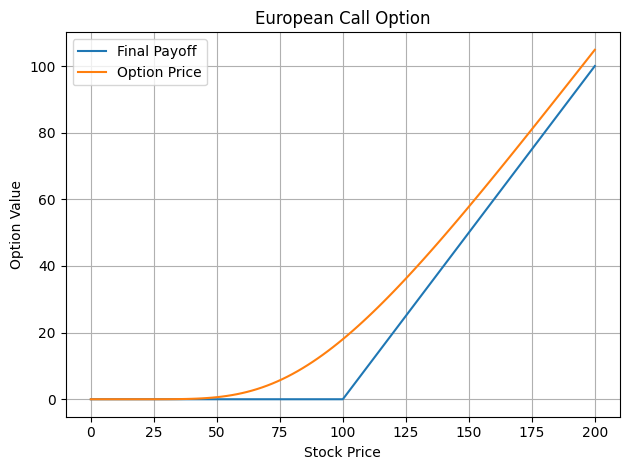

In [11]:
plt.plot(S, np.maximum(S - K, 0), label='Final Payoff')
plt.plot(S, V, label='Option Price')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('European Call Option')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('figures/crank-nicolson.jpg', dpi=300)
plt.show()

In [12]:
def black_scholes(S, K, T, r, sigma):
    S = np.array(S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [13]:
black_scholes_prices = black_scholes(S, K, T, r, sigma)

/var/folders/mp/4wh54f210fs0z9blnbg386280000gn/T/ipykernel_10982/2794284487.py:3: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


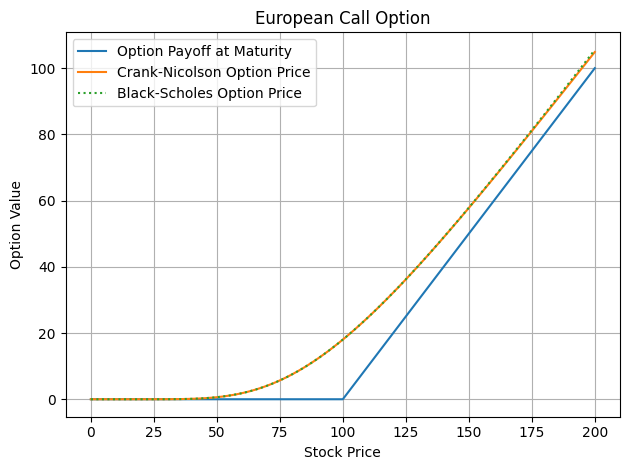

In [14]:
plt.plot(S, np.maximum(S - K, 0), label='Option Payoff at Maturity')
plt.plot(S, V, label='Crank-Nicolson Option Price')
plt.plot(S, black_scholes_prices, label='Black-Scholes Option Price', linestyle=':')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('European Call Option')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('figures/crank-with-black-scholes.jpg', dpi=300)
plt.show()

In [15]:
range1 = [i for i, s in enumerate(S) if s % 5 == 0 and s >= 90]
range2 = [i for i, s in enumerate(S) if 90 <= s <= 110 and s % 2 == 0]

selected_indices = sorted(set(range1 + range2))

stock_prices = S[selected_indices]
crank_nicolson_prices = V[selected_indices]
bs_prices_selected = black_scholes_prices[selected_indices]

print(f"{'Stock Price ($)':>15} | {'Crank-Nicolson':>17} | {'Black-Scholes':>15} | {'Abs Error':>10}")
print("-" * 67)

for i in selected_indices:
    s = S[i]
    cn_price = V[i]
    bs_price = black_scholes_prices[i]
    error = abs(cn_price - bs_price)
    print(f"{s:15.0f} | {cn_price:17.4f} | {bs_price:15.4f} | {error:10.4f}")

Stock Price ($) |    Crank-Nicolson |   Black-Scholes |  Abs Error
-------------------------------------------------------------------
             90 |           12.2442 |         12.2497 |     0.0055
             92 |           13.3151 |         13.3208 |     0.0057
             94 |           14.4289 |         14.4349 |     0.0060
             96 |           15.5845 |         15.5908 |     0.0063
             98 |           16.7807 |         16.7873 |     0.0066
            100 |           18.0159 |         18.0230 |     0.0070
            102 |           19.2890 |         19.2965 |     0.0075
            104 |           20.5984 |         20.6064 |     0.0080
            106 |           21.9428 |         21.9515 |     0.0087
            108 |           23.3208 |         23.3302 |     0.0094
            110 |           24.7310 |         24.7413 |     0.0103
            120 |           32.2171 |         32.2343 |     0.0172
            130 |           40.3116 |         40.3420 |     0

### The following is Crank-Nicolson with PSOR for American Put option

In [16]:
K = 100
T = 1.0
r = 0.05
sigma = 0.4

In [17]:
S_max = 200
M = 100
N = 1_000
w = 1.2
tol = 1e-6

In [18]:
dS = S_max / M
dt = T / N

In [19]:
S = np.linspace(0, S_max, M + 1)
V = np.maximum(K - S, 0)    # put payoff
payoff = np.maximum(K - S, 0)

In [20]:
j = np.arange(M + 1)
alpha = 0.25 * dt * (sigma**2 * j**2 - r * j)
beta = 0.5 * dt * (sigma**2 * j**2 + r)
gamma = 0.25 * dt * (sigma**2 * j**2 + r * j)
alpha.shape, beta.shape, gamma.shape

((101,), (101,), (101,))

In [21]:
A_lower = -alpha[2:M]
A_diag = 1 + beta[1:M]
A_upper = -gamma[1:M-1]
A = np.diag(A_diag) + np.diag(A_lower, k=-1) + np.diag(A_upper, k=1)
A.shape

(99, 99)

In [22]:
B_lower = alpha[2:M]
B_diag = 1 - beta[1:M]
B_upper = gamma[1:M-1]
B = np.diag(B_diag) + np.diag(B_lower, k=-1) + np.diag(B_upper, k=1)
B.shape

(99, 99)

In [23]:
for n in range(N):
    b = B @ V[1:M]
    b[0] += alpha[1] * (V[0] + K)
    b[-1] += gamma[M-1] * (V[M] + 0)

    V_old = V[1:M].copy()
    error = np.inf
    while error > tol:
        V_new = V_old.copy()
        for i in range(M - 1):
            y = b[i] - (A[i][:i] @ V_new[:i]) - (A[i][i+1:] @ V_old[i+1:])
            V_new[i] = max(payoff[i+1], (1 - w) * V_old[i] + y * (w / A[i][i]))
        error = np.linalg.norm(V_new - V_old, np.inf)
        V_old = V_new.copy()

    V[1:M] = V_new

    V[0] = K
    V[M] = 0

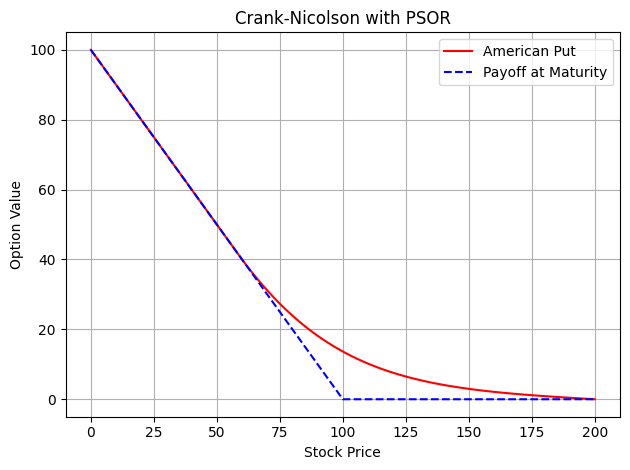

In [24]:
plt.plot(S, V, color='r', label='American Put')
plt.plot(S, payoff, color='b', label='Payoff at Maturity', linestyle='--')
plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.title('Crank-Nicolson with PSOR')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('figures/crank-sor.jpg', dpi=300)
plt.show()